In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import abtem
import os
import dask
import importlib
import helper_funcs
from helper_funcs import create_parameter_list
from ase.io import read, write
from ase.visualize import view

#setting configuration
abtem.config.set({"device": "gpu", "fft": "fftw"})
dask.config.set({"num_workers": 1})

### RAW

In [3]:
#CHOOSE - which data?

data_dir = './data/data_DFT/results/'

In [4]:
#import preparation
data_names = [entry for entry in os.listdir(data_dir) if entry.endswith('.zarr')]
measurements_list = [None] * len(data_names)
#sort by timestamp
data_names.sort()

#fill measurements_list with imported data
for i in range(len(data_names)):
    path = f'{data_dir}{data_names[i]}'
    measurements_list[i] = abtem.from_zarr(path).compute()

[########################################] | 100% Completed | 102.05 ms
[########################################] | 100% Completed | 104.71 ms
[########################################] | 100% Completed | 102.70 ms
[########################################] | 100% Completed | 102.70 ms


In [5]:
len(measurements_list)

4

In [6]:
data_names

['20240918180059_relax_pathC_Nsite.traj_RAW.zarr',
 '20240918184208_relax_pathC_Bsite.traj_RAW.zarr',
 '20240918192307_relax_hBN_B4_outplane.traj_RAW.zarr',
 '20240918193004_relax_hBN_B4_inplane.traj_RAW.zarr']

In [7]:
#params1 = ['_'.join([name.split('_')[1], name.split('_')[2].lstrip('path'), name.split('_')[3].rstrip('.traj')]) for name in data_names[:2]]
#params2 = ['_'.join([name.split('_')[1], name.split('_')[3].rstrip('4'), 'Nsite\n', name.split('_')[4].rstrip('.traj')]) for name in data_names[2:]]

#MANUAL INPUT! 
params1 = ['DFT vacancyN filledwithC', 'DFT vacancyB filledwithC']
params2 = ['DFT vacancyN filledwithB\noutplane', 'DFT vacancyN filledwithB\ninplane']

parameter_info = [params1, params2] # seperation for plots below

In [8]:
#measurements = abtem.stack([m for m in measurements_list], parameter_info)
measurements1 = abtem.stack([m for m in measurements_list[:2]], params1)
measurements2 = abtem.stack([m for m in measurements_list[2:]], params2)
measurements = [measurements1, measurements2]

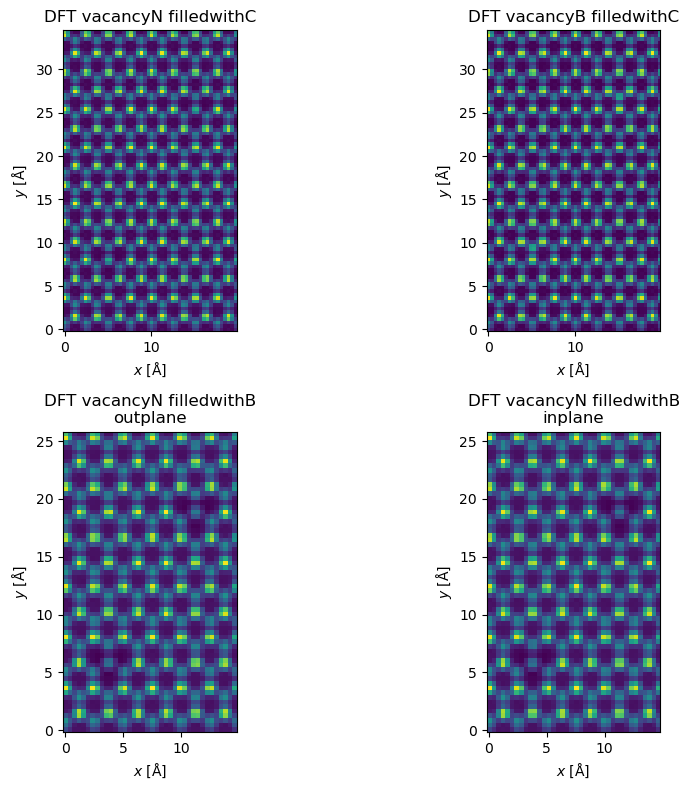

In [9]:
#plot RAW
#CHOOSE:
columns = 2
zoom = 'no' #'yes' for zooming in

#FIX
rows = int(np.ceil(len(measurements_list)/columns))
fig, axs = plt.subplots(rows, columns, figsize=(10, rows*4))

i=0
for row in range(rows):
    for col in range(columns):
        try:
            measurements[row][col].show(ax=axs[row, col], explode=False, cbar=False, title=True)
            axs[row, col].set_title(parameter_info[row][col])
            i += 1

            if zoom == 'yes':
                axs[row, col].set_ylim(25,35)
                axs[row, col].set_xlim(20,30)
        except IndexError:
            axs[row, col].set_visible(False)
        
plt.tight_layout()

### INTERPOLATED + GAUSS

In [10]:
#set parameters for postprocessing
#pairs: interpolate:0.01 & gauss: 0.2;  interpolate:0.05 & gauss: 0.3
#interpolate-> higher value (0.1) more pixels; low value -> smoother, more time
interpolate = 0.01
gauss = 0.3
dose = 1e9

In [11]:
#interpolate to smooth images and apply gaussian filter to consider partial spatial coherence 
final_measurements1 = measurements1.interpolate(interpolate).gaussian_filter(gauss)
final_measurements2 = measurements2.interpolate(interpolate).gaussian_filter(gauss)
final_measurements = [final_measurements1, final_measurements2]

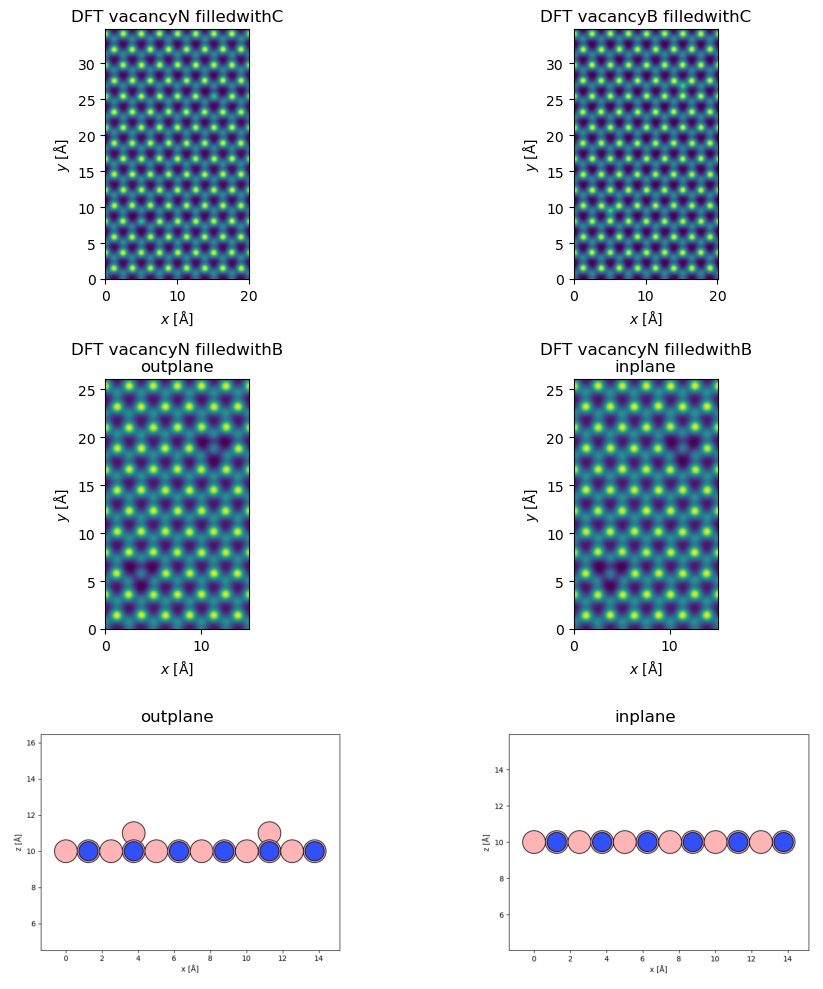

In [30]:
#plot
#CHOOSE:
columns = 2
zoom = 'no' #'yes' for zooming in

#FIX
rows = int(np.ceil(len(measurements_list)/columns))
fig, axs = plt.subplots(rows + 1, columns, figsize=(10, rows*5))

i=0
for row in range(rows):
    for col in range(columns):
        try:
            final_measurements[row][col].show(ax=axs[row, col], explode=False, cbar=False, title=True) 
            
            #axs[row, col].set_title(parameter_info_sorted[0][i])
            axs[row, col].set_title(parameter_info[row][col])

            i += 1

            if zoom == 'yes':
                axs[row, col].set_ylim(2,12)
                axs[row, col].set_xlim(1,9)
        except IndexError:
            axs[row, col].set_visible(False)

#
im_out = plt.imread('./data/data_DFT/images/structure/outplane.png')
im_in = plt.imread('./data/data_DFT/images/structure/inplane.png')
images = [im_out, im_in]

row = rows
for i in range(2):
    axs[row, i].imshow(images[i])
    axs[row, i].set_axis_off()

axs[row, 0].set_title('outplane')
axs[row, 1].set_title('inplane')


#plt.subplots_adjust(wspace = 0.1)
#fig.set_facecolor('yellow')
plt.tight_layout()


#fig.figure.savefig('./data/data_DFT/images/DFT_BvsC1.png', bbox_inches='tight')

In [21]:
from matplotlib.gridspec import GridSpec

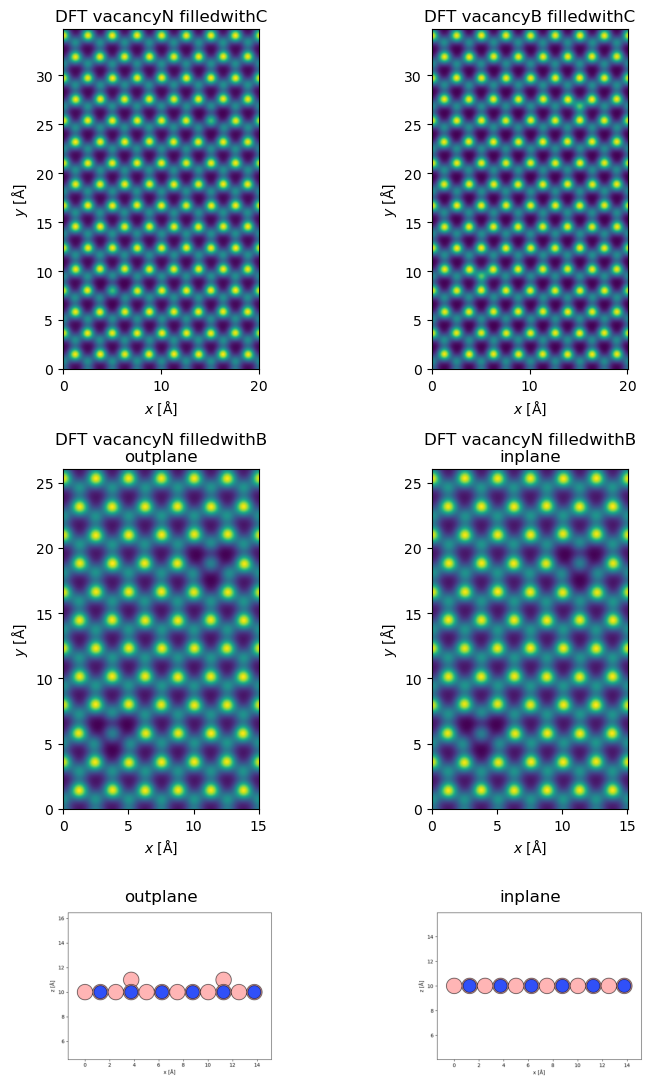

In [59]:
#plot
#CHOOSE:
columns = 2
zoom = 'no' #'yes' for zooming in

#FIX
rows = int(np.ceil(len(measurements_list)/columns))
#fig, axs = plt.subplots(rows + 1, columns, figsize=(10, rows*5))

fig = plt.figure(figsize=(8,11))

gs = GridSpec(3, 2, height_ratios=[3,3, 1.5],figure=fig)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])
ax5 = fig.add_subplot(gs[4])
ax6 = fig.add_subplot(gs[5])
axs = [ax1, ax2, ax3, ax4, ax5, ax6]

i=0
for row in range(rows):
    for col in range(columns):
        
        try:
            final_measurements[row][col].show(ax=axs[i], explode=False, cbar=False, title=True) 
            
            #axs[row, col].set_title(parameter_info_sorted[0][i])
            axs[i].set_title(parameter_info[row][col])

            if zoom == 'yes':
                axs[i].set_ylim(2,12)
                axs[i].set_xlim(1,9)
                
            i += 1
                
        except IndexError:
            axs[i].set_visible(False)

#
im_out = plt.imread('./data/data_DFT/images/structure/outplane_xz.png')
im_in = plt.imread('./data/data_DFT/images/structure/inplane_xz.png')
images = [im_out, im_in]

for i in range(2):
    axs[i+4].imshow(images[i])
    axs[i+4].set_axis_off()

axs[4].set_title('outplane')
axs[5].set_title('inplane')


#plt.subplots_adjust(hspace = 0.5)
#fig.set_facecolor('yellow')
plt.tight_layout()


#fig.figure.savefig('./data/data_DFT/images/DFT_BvsC.png', bbox_inches='tight')

### NOISE

In [52]:
#noise to account for finite electrone dose -> statistic deviation (see abtem walkthrough -> scan & detect)
noisy_measurements1 = final_measurements1.poisson_noise(dose_per_area=dose, seed=100)
noisy_measurements2 = final_measurements2.poisson_noise(dose_per_area=dose, seed=100)
noisy_measurements = [noisy_measurements1, noisy_measurements2]

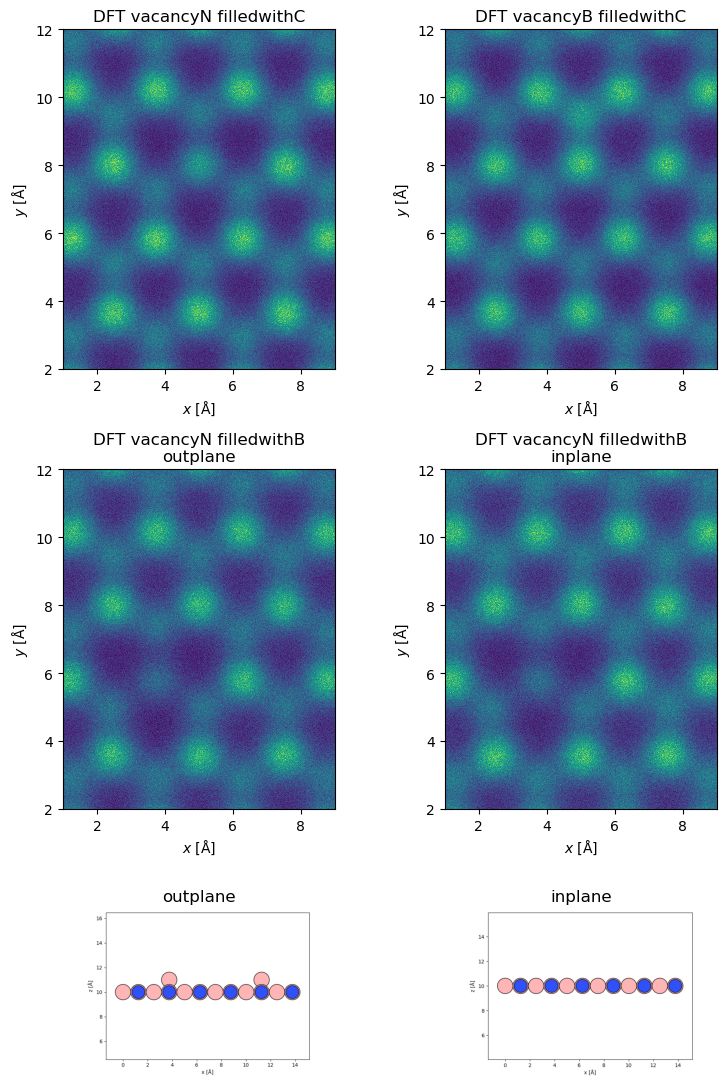

In [57]:
#plot
#CHOOSE:
columns = 2
zoom = 'yes' #'yes' for zooming in

#FIX
rows = int(np.ceil(len(measurements_list)/columns))
#fig, axs = plt.subplots(rows + 1, columns, figsize=(10, rows*5))

fig = plt.figure(figsize=(8,11))

gs = GridSpec(3, 2, height_ratios=[3,3, 1.5],figure=fig)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])
ax5 = fig.add_subplot(gs[4])
ax6 = fig.add_subplot(gs[5])
axs = [ax1, ax2, ax3, ax4, ax5, ax6]

i=0
for row in range(rows):
    for col in range(columns):
        
        try:
            noisy_measurements[row][col].show(ax=axs[i], explode=False, cbar=False, title=True) 
            
            #axs[row, col].set_title(parameter_info_sorted[0][i])
            axs[i].set_title(parameter_info[row][col])

            if zoom == 'yes':
                axs[i].set_ylim(2,12)
                axs[i].set_xlim(1,9)
                
            i += 1
                
        except IndexError:
            axs[i].set_visible(False)

#
im_out = plt.imread('./data/data_DFT/images/structure/outplane_xz.png')
im_in = plt.imread('./data/data_DFT/images/structure/inplane_xz.png')
images = [im_out, im_in]

for i in range(2):
    axs[i+4].imshow(images[i])
    axs[i+4].set_axis_off()

axs[4].set_title('outplane')
axs[5].set_title('inplane')


#plt.subplots_adjust(hspace = 0.5)
#fig.set_facecolor('yellow')
plt.tight_layout()


#fig.figure.savefig('./data/data_DFT/images/DFT_BvsC_noisy_zoom.png', bbox_inches='tight')

In [13]:
#noisy_measurements_plot = abtem.stack(noisy_measurements, parameter_info)
#noisy_measurements_plot[5:7].show(explode=True, figsize=(12, 4))


### View: Outplane vs Inplane

In [14]:
atoms_outplane = read('./data/data_DFT/relax_hBN_B4_outplane.traj', index = ':')
atoms_inplane = read('./data/data_DFT/relax_hBN_B4_inplane.traj', index = ':')

#image_out  = write('./data/data_DFT/outplane.png', atoms_outplane[0])
#image_in  = write('./data/data_DFT/inplane.png', atoms_inplane[0])


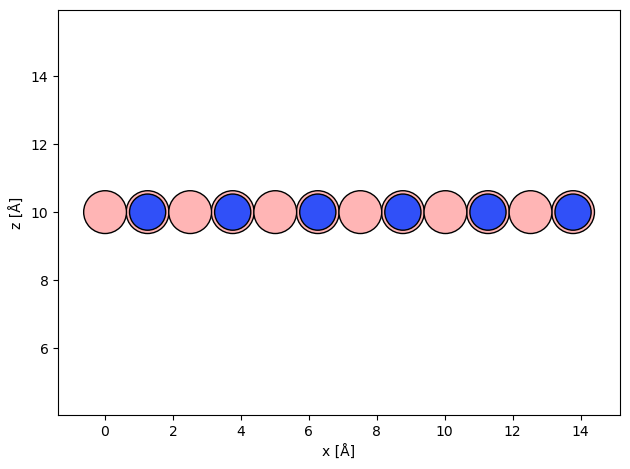

In [61]:
fig, ax1 = plt.subplots(1, 1)
atoms = atoms_outplane[0]
atoms_orth = abtem.orthogonalize_cell(atoms)
abtem.show_atoms(atoms_orth, plane='xz',show_cell=False, ax=ax1,)

fig.tight_layout()
#fig.figure.savefig('./data/data_DFT/images/structure/outplane.png', bbox_inches='tight')

AttributeError: 'tuple' object has no attribute 'plot'

In [24]:
#view(atoms_outplane[0], viewer='x3d')
view(a_orth, viewer='x3d')

In [19]:
#view(atoms_outplane[0], viewer='x3d')
view(a_orth, viewer='x3d')